### based on https://github.com/higgsfield/RL-Adventure

In [1]:
%matplotlib inline
import collections
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import time
import keras as ks
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
env = gym.make('CartPole-v1')
#env = env.unwrapped

In [3]:
class Replay(object):
    def __init__(self, maxlen=1000):
        self.buffer = collections.deque(maxlen=maxlen)
    def add(self, state, action, next_state, reward, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, next_state, reward, done))
    def sample(self, n):
        state, action, next_state, reward, done = zip(*random.sample(self.buffer, n))
        state = np.concatenate(state, axis=0)
        next_state = np.concatenate(next_state, axis=0)
        reward = np.array(reward)
        done = np.array(done)
        return state, action, next_state, reward, done
    def __len__(self):
        return len(self.buffer)

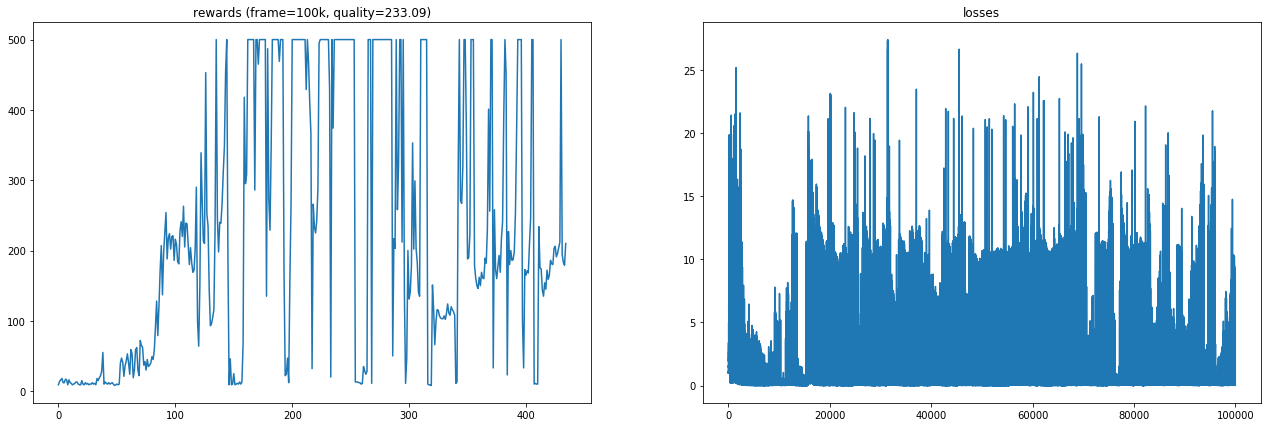

In [4]:
def build_model():
    model = ks.Sequential([
        ks.layers.Dense(32, input_shape=env.observation_space.shape, activation='relu'),
#        ks.layers.Dense(64, activation='relu'),
#        ks.layers.Dense(32, activation='relu'),
        ks.layers.Dense(env.action_space.n)
    ])
    opt = ks.optimizers.Nadam()
    loss = ks.losses.mean_squared_error
    model.compile(opt, loss)
    return model

DOUBLE_MODEL = True
def blend_models(dst, src, k):
    if src is dst:
        return
    sw = src.get_weights()
    dw = dst.get_weights()
    for n in range(len(sw)):
        dw[n] = sw[n] * k + dw[n] * (1 - k)
    dst.set_weights(dw)
    
model = build_model()
target_model = build_model() if DOUBLE_MODEL else model
#model.summary()

replay = Replay(1000)
batch_size = 32
epsilon = 1.0
gamma = 0.95

all_rewards = [0]
losses = []
    
state = env.reset()
for frame in range(100000):
    epsilon = max(0.01, epsilon * 0.995)
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q = model.predict(np.expand_dims(state, 0))
        action = np.argmax(q, 1)[0]

    next_state, reward, done, info = env.step(action)
    replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward
    state = next_state
    
    if done:
        all_rewards.append(0)
        state = env.reset()
    
    if len(replay) > batch_size:
        q_state, q_action, q_next_state, q_reward, q_done = replay.sample(batch_size)
        target = target_model.predict(q_state)
        q_expect = q_reward + gamma * (1 - q_done) * np.amax(target_model.predict(q_next_state), 1)
        loss = 0
        for n, (action, expect) in enumerate(zip(q_action, q_expect)):
            p = target[n, action]
            target[n, action] = expect
            loss += (p - expect) ** 2
        losses.append(loss / batch_size)
        model.fit(q_state, target, epochs=1, verbose=0)
    
    if (frame + 1) % 4 == 0:
        blend_models(target_model, model, 0.5)
    
    quality = 0 if len(all_rewards) < 100 else np.mean(all_rewards[-100:])
    solved = quality > 475
    if (frame + 1) % 1000 == 0 or solved:
        clear_output(False)
        plot.figure(figsize=(22,7))
        plot.subplot(121)
        plot.title('rewards (frame=%dk, quality=%g)' % (np.round(frame/1000), quality))
        plot.plot(all_rewards[:-1])
        plot.subplot(122)
        plot.title('losses')
        plot.plot(losses)
        plot.show();
    
    if solved:
        print('solved.')
        break